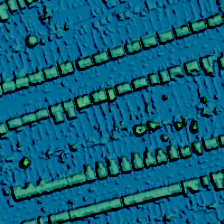

In [1]:
from IPython.display import Image
Image(filename='LIDAR/LIDAR_24974.png') 

In [1]:
# imports
import numpy as np
import pandas as pd
import h5py as h5py
import PIL

# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image and directories
#import cv2
import os

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras

In [2]:
# read csv file
df = pd.read_csv("EmbeddingData_C3_9528.csv")

# add a path column to augment the absolute path of the image
df["path"] = [os.path.join("LIDAR/", "LIDAR_" + str(i) + '.png') for i in df.id.values]
df["path"][0]

'LIDAR/LIDAR_48552.png'

In [3]:
# create train and test split
train, test = train_test_split(df, 
                               test_size = 0.225,
                               random_state = 250918939)

## preparing the model

In [4]:
# check running time
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16367262059075039945
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4155965440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13730991801835170683
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
# download ResNet from Google
import tensorflow.keras.layers
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
initial_model = ResNet50V2(weights = "imagenet",
                 include_top = False,
                 input_shape=(224,224,3))

In [5]:
# define the pre-trained parameters to be untrainable
initial_model.trainable = False
#initial_model.summary()

## add head layers

In [6]:
# input layer
input = keras.Input(shape=(224,224)+(3,),name = "iamge_only_input")

# define a temporary model to construct the whole ResNet model
tempModel = initial_model(input,training=False)

In [7]:
# now start to add head layers
tempModel = Flatten()(tempModel)

# add dense layers and drop out
tempModel = Dense(64, activation="relu")(tempModel)
tempModel = Dropout(0.5)(tempModel)
tempModel = Dense(32, activation="relu")(tempModel)
tempModel = Dropout(0.5)(tempModel)



# final output layer
output = Dense(1, activation="relu")(tempModel)

# put all together
ResnetModel = keras.Model(input, output)

In [8]:
ResnetModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
iamge_only_input (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0     

## define image generators

In [7]:
# define the parameters
from tensorflow.keras.applications.resnet_v2 import preprocess_input
input_size = (224,224)
batch = 32
DataDirectory = 'LIDAR'

# define image generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale =None,
    shear_range=0,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale =None,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=preprocess_input
)

# point to data
train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='.',
    x_col='path',
    y_col='education',
    target_size=input_size,
    batch_size=batch,
    shuffle=True,
    class_mode='raw',
    subset='training',
    interpolation='bilinear'
)

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='.',
    x_col='path',
    y_col='education',
    target_size=input_size,
    batch_size=batch,
    shuffle=True,
    class_mode='raw',
    subset='validation',
    interpolation='bilinear'
)

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='.',
    x_col='path',
    y_col='education',
    target_size=input_size,
    batch_size=batch,
    shuffle=False,
    class_mode='raw',
    interpolation='bilinear'
)

Found 22768 validated image filenames.
Found 5692 validated image filenames.
Found 8263 validated image filenames.


## Warming up the model

In [9]:
# compile the model with warm-up learning rate,
initial_model.trainable = False
opt = optimizers.Adam(learning_rate = 0.000001, decay = 0.001/100)
ResnetModel.compile(loss='mean_squared_error',optimizer=opt,metrics=[keras.metrics.mean_squared_error])
#ResnetModel.summary()

In [13]:
# warming up the model with 2 epochs and half the regular step size
ResnetModel.fit(
    train_generator,
    epochs = 2,
    validation_data = validation_generator,
    steps_per_epoch =711,
    validation_steps=177
)

Epoch 1/2
711/711 [==============================] - 311s 438ms/step - loss: 153.3801 - mean_squared_error: 153.3801 - val_loss: 110.1336 - val_mean_squared_error: 110.1336
Epoch 2/2
711/711 [==============================] - 311s 437ms/step - loss: 150.8490 - mean_squared_error: 150.8490 - val_loss: 107.6208 - val_mean_squared_error: 107.6208


## training the whole model

In [10]:
# now training the whole model
initial_model.trainable=True

# recompile the model
opt = optimizers.Adam(learning_rate = 9e-7, decay = 0.001/200)
ResnetModel.compile(loss='mean_squared_error',optimizer=opt,metrics=[keras.metrics.mean_squared_error])

#ResnetModel.summary()

In [19]:
# add callback
checkpoint_path = 'checkpoint3-4/ResnetModel.{val_loss:.3f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

def scheduler(epoch,lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.15)


my_callback = [
    # save the weights of the best performing model to the checkpoint folder
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                      save_best_only=True,
                      save_weights_only=True),
    # strop training when validation error stays within 0.001 for 5 rounds
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                      min_delta = 0.001,
                      patience=15),
    # training with a declining learning rate
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
]

In [21]:
# train the whole model
epochs = 10

ResnetModel.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=711,
    validation_steps=177, 
    callbacks=my_callback
)

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 1.9999999949504854e-06.
711/711 [==============================] - 317s 441ms/step - loss: 88.9125 - mean_squared_error: 88.9125 - val_loss: 73.3715 - val_mean_squared_error: 73.3715
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 1.9999999949504854e-06.
711/711 [==============================] - 311s 437ms/step - loss: 88.5203 - mean_squared_error: 88.5203 - val_loss: 80.6348 - val_mean_squared_error: 80.6348
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(1.7214159e-06, shape=(), dtype=float32).
711/711 [==============================] - 312s 439ms/step - loss: 87.4389 - mean_squared_error: 87.4389 - val_loss: 80.1978 - val_mean_squared_error: 80.1978
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(1.4816363e-06, shape=(), dtype=float32).
711/711 [==============================] - 312s 438ms/step - loss: 86.6994 - mean

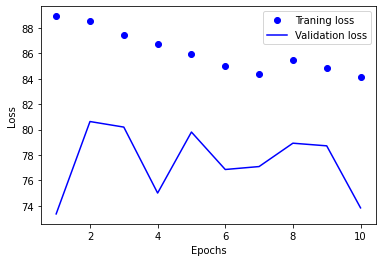

In [22]:
# check graph
loss = ResnetModel.history.history["loss"]
val_loss = ResnetModel.history.history["val_loss"]
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, "bo", label="Traning loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
#plt.ylim([65,85])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## test performance

In [24]:
# define the loss function (mse)
def mean_squared_loss(ytrue,ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    return np.mean((ytrue-ypred)**2)

In [25]:
# assess the performance

#ResnetModel = keras.models.load_model("my_Resnet")
#ResnetModel.load_weights("checkpoint3-3/ResnetModel.72.110.h5")
test_generator.reset()
prediction = ResnetModel.predict(test_generator)
prediction = prediction.reshape(-1)
mse = mean_squared_loss(test_generator.labels,prediction)
print("The mean squared error of prediction is %.3f" % (mse))

The mean squared error of prediction is 79.146
